# РАЗМЕЩЕНИЕ ПРЯМОУГОЛЬНИКОВ НА ЛИСТЕ С ПОМОЩЬЮ ГНЕТИЧЕСКОГО АЛГОРИТМА

**Функция приспособенности**

в нашем случае - выход за границу и наложение прямоугольников друг на друга

**Имитация эволюционного процесса:**

1. Отбор наиболее приспособленных: 
   
   Цель - оставить в популяции наиболее приспособленных, но сохранить популяционное разнообразие.
   
   Турнирный отбор - отбор случайным образом несколько индиивидумов и среди отобранных - отбирается лучший
   
   Есть другие способы отбора
   
2. Crossing (Скрещивание) родителей для получения новых индивидуумов

   Из пар родителей выбирают фрагменты хромосом и их перемешивают
   
   Одноточечное скрещивание - случайным образом выбирается точка разреза хромосом у родителей, 
   затем осуществляется обмен их частей. Так появляется два потомка. Тогда размер популяции не менятеся.
   
3. Мутация - случайное изменение отдельных генов.
   
   С малой вероятностью меняется (инвертируется) гены.

In [1]:
import random
import numpy as np
import scipy

In [2]:
# константы задачи
ONE_MAX_LENGTH = 2 * 10    # длина подлежащей оптимизации строки
 
# константы генетического алгоритма
POPULATION_SIZE = 100    # количество индивидуумов в популяции
P_CROSSOVER = 0.9        # вероятность скрещивания
P_MUTATION = 0.1         # вероятность мутации индивидуума
MAX_GENERATIONS = 500    # максимальное количество поколений

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [3]:
H = 8
W = 10
R = [1., 2., 2.]
# сначала h(y), потом w(x)
TYPE_Rec = [10, 5, 6, 3, 3, 3]
N_R = len(R)

In [4]:
class FitnessMax():
    def __init__(self):
        self.values = [0]
 
 
class Individual(list):
    def __init__(self, *args):
        super().__init__(*args)
        self.fitness = FitnessMax()
        
def oneMaxFitness(individual):
    
    inf = 1000
    FRAME = 3 
    P0 = np.zeros((H, W))
    k = 5 # насколько рамка слева и снизу большая
    P = np.zeros((H + FRAME * k, W + FRAME * k))
    P += inf
    P[FRAME : H + FRAME, FRAME : W + FRAME] = P0
    for i in range(0, len(individual), 2):
        x1, y1 = individual[i : i+2]
        w, h = TYPE_Rec[i : i+2]
        x2 = x1 + w
        y2 = y1 + h
        Rectangular = np.zeros((y2 - y1, x2 - x1))
        Rectangular += 1
        P[FRAME + y1 : FRAME + y2, FRAME + x1 : FRAME + x2] += Rectangular 
    P = np.intc(P)  

    # то, что вышло за рамки
    S1 = P[P > inf].sum()
    # то, что наложилось 
    S2 = P[np.bitwise_and(P > 1, P < inf)].sum()
    S = S1 + S2
    
    S = -S # так как алгоритм максимизирует значение
    return S, # кортеж

def individualCreator():
    # левая нижняя точка
    Rectangular = []
    for i in range(N_R):
        x0 = random.randint(0, W)
        y0 = random.randint(0, H)
        Rectangular.extend([x0, y0])
    return Individual(Rectangular)
 
def populationCreator(n = 0):
    return list([individualCreator() for i in range(n)])

In [5]:
population = populationCreator(n = POPULATION_SIZE) 
generationCounter = 0

In [6]:
fitnessValues = list(map(oneMaxFitness, population))
# fitnessValues

In [7]:
for individual, fitnessValue in zip(population, fitnessValues):
    individual.fitness.values = fitnessValue
    
maxFitnessValues = []
meanFitnessValues = []

def clone(value):
    ind = Individual(value[:])
    ind.fitness.values[0] = value.fitness.values[0]
    return ind

# выполнения турнирного отбора
def selTournament(population, p_len):
    offspring = []
    for n in range(p_len):
        i1 = i2 = i3 = 0
        while i1 == i2 or i1 == i3 or i2 == i3:
            i1, i2, i3 = random.randint(0, p_len-1), random.randint(0, p_len-1), random.randint(0, p_len-1)
        offspring.append(max([population[i1], population[i2], population[i3]], key=lambda ind: ind.fitness.values[0]))
    return offspring

# одноточечное скрещивание 
def cxOnePoint(child1, child2):
    s = random.randint(1,2) * 2
    child1[s:], child2[s:] = child2[s:], child1[s:]

# мутация
def mutFlipBit(mutant, indpb=0.01):
    for indx in range(0, len(mutant), 2):
        if random.random() < indpb:
            x0 = random.randint(0, W)
            y0 = random.randint(0, H)
            mutant[indx] = x0 
            mutant[indx+1] == y0

In [8]:
# individual

In [9]:
fitnessValues = [individual.fitness.values[0] for individual in population]

In [10]:
while max(fitnessValues) < 0 and generationCounter < MAX_GENERATIONS:
    generationCounter += 1
    offspring = selTournament(population, len(population))
    offspring = list(map(clone, offspring))
 
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSOVER:
            cxOnePoint(child1, child2)
 
    for mutant in offspring:
        if random.random() < P_MUTATION:
            mutFlipBit(mutant, indpb=1.0/ONE_MAX_LENGTH)
 
    freshFitnessValues = list(map(oneMaxFitness, offspring))
    for individual, fitnessValue in zip(offspring, freshFitnessValues):
        individual.fitness.values = fitnessValue
 
    population[:] = offspring
 
    fitnessValues = [ind.fitness.values[0] for ind in population]
 
    maxFitness = max(fitnessValues)
    meanFitness = sum(fitnessValues) / len(population)
    maxFitnessValues.append(maxFitness)
    meanFitnessValues.append(meanFitness)
    print(f"Поколение {generationCounter}: Макс приспособ. = {maxFitness}, Средняя приспособ.= {meanFitness}")
 
    best_index = fitnessValues.index(max(fitnessValues))
    print("Лучший индивидуум = ", *population[best_index], "\n")

Поколение 1: Макс приспособ. = -28, Средняя приспособ.= -27004.56
Лучший индивидуум =  0 0 1 3 5 5 

Поколение 2: Макс приспособ. = -27, Средняя приспособ.= -16890.36
Лучший индивидуум =  0 0 2 4 4 3 

Поколение 3: Макс приспособ. = -20, Средняя приспособ.= -10669.03
Лучший индивидуум =  0 0 2 4 1 5 

Поколение 4: Макс приспособ. = -18, Средняя приспособ.= -4996.9
Лучший индивидуум =  0 0 3 5 1 1 

Поколение 5: Макс приспособ. = -16, Средняя приспособ.= -1564.06
Лучший индивидуум =  0 0 3 5 2 3 

Поколение 6: Макс приспособ. = -6, Средняя приспособ.= -127.34
Лучший индивидуум =  0 0 0 5 5 5 

Поколение 7: Макс приспособ. = -6, Средняя приспособ.= -172.48
Лучший индивидуум =  0 0 0 5 5 5 

Поколение 8: Макс приспособ. = -6, Средняя приспособ.= -138.67
Лучший индивидуум =  0 0 0 5 6 4 

Поколение 9: Макс приспособ. = -6, Средняя приспособ.= -43.95
Лучший индивидуум =  0 0 3 5 1 5 

Поколение 10: Макс приспособ. = -6, Средняя приспособ.= -270.12
Лучший индивидуум =  0 0 0 5 5 5 

Поколени

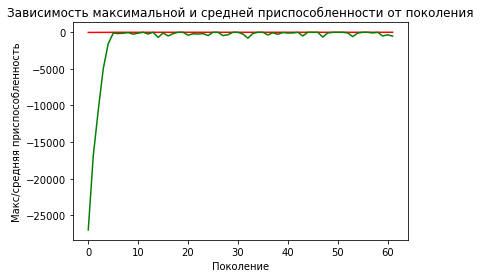

In [11]:
import matplotlib.pyplot as plt
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
plt.show()

In [12]:
## H = 8
W = 10


individual = [0, 0, 0, 5, 6, 5]
# 0 3 1 1 3 5

inf = 10
FRAME = 3 
P0 = np.zeros((H, W))
k = 4 # насколько рамка слева и снизу большая
P = np.zeros((H + FRAME * k, W + FRAME * k))
P += inf
P[FRAME : H + FRAME, FRAME : W + FRAME] = P0
for i in range(0, len(individual), 2):
    x1, y1 = individual[i : i+2]
    w, h = TYPE_Rec[i : i+2]
    x2 = x1 + w
    y2 = y1 + h
    Rectangular = np.zeros((y2 - y1, x2 - x1))
    Rectangular += 1
    P[FRAME + y1 : FRAME + y2, FRAME + x1 : FRAME + x2] += Rectangular 
P = np.intc(P)  

for i in range(len(P)):
    print(P[i], sep='\t')
    
# то, что вышло за рамки
S1 = P[P > inf].sum()
# то, что наложилось 
S2 = P[np.bitwise_and(P > 1, P < inf)].sum()
S = S1 + S2

# так как алгоритм максимизирует значение
S = -S
print(S)

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10  1  1  1  1  1  1  1  1  1  1 10 10 10 10 10 10 10 10 10]
[10 10 10  1  1  1  1  1  1  1  1  1  1 10 10 10 10 10 10 10 10 10]
[10 10 10  1  1  1  1  1  1  1  1  1  1 10 10 10 10 10 10 10 10 10]
[10 10 10  1  1  1  1  1  1  1  1  1  1 10 10 10 10 10 10 10 10 10]
[10 10 10  1  1  1  1  1  1  1  1  1  1 10 10 10 10 10 10 10 10 10]
[10 10 10  1  1  1  1  1  1  1  1  1  0 10 10 10 10 10 10 10 10 10]
[10 10 10  1  1  1  1  1  1  1  1  1  0 10 10 10 10 10 10 10 10 10]
[10 10 10  1  1  1  1  1  1  1  1  1  0 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10